In [25]:
import numpy as np
from scipy import linalg, io, sparse
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import gurobipy as gp
from gurobipy import GRB

sns.set()
##ENSURE THAT FILE linearprogramming.py is in same directory!
from linearprogramming import *  

# Linear Programs:

We consider Linear programs in the form:

$
\mathrm{min}\, g^\top x \\
\mathrm{st.}\, A^\top x = b, \\
\quad l \leq x \leq u.
$ 

## Part 3

We wish to transform the following problem into the above form:

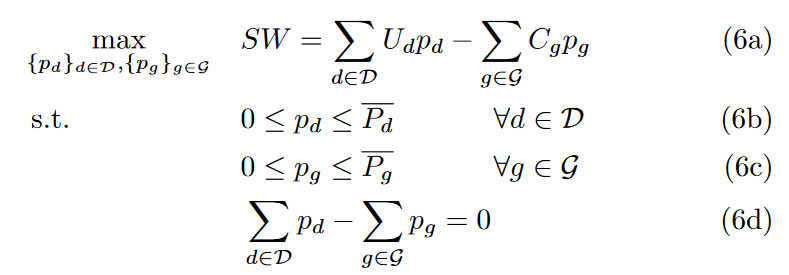

let us denote all $p_d$ as $P_d$ and all $p_g$ as $P_g$. We can finally rewrite the problem as:

$
\mathrm{min}\, \begin{bmatrix} -U \\ C \end{bmatrix}^\top \begin{bmatrix} P_d \\ P_g\end{bmatrix} \\[1 ex]
\mathrm{st.}\, \begin{bmatrix} e \\ -e \end{bmatrix}^\top \begin{bmatrix} P_d \\ P_g\end{bmatrix} = 0, \\[1 ex]
\begin{bmatrix} 0 \\ 0 \end{bmatrix} \leq \begin{bmatrix} P_d \\ P_g\end{bmatrix} \leq \begin{bmatrix} \bar{P_d} \\ \bar{P_g} \end{bmatrix}.
$

Thus we have:

$
x = \begin{bmatrix} P_d \\ P_g\end{bmatrix},\quad g = \begin{bmatrix} -U \\ C \end{bmatrix},\quad A = \begin{bmatrix} e \\ -e \end{bmatrix},\quad b = 0,\quad l = \begin{bmatrix} 0 \\ 0 \end{bmatrix},\quad u = \begin{bmatrix} \bar{P_d} \\ \bar{P_g} \end{bmatrix}
$

In [26]:
#Loading the test data and casting to common datatype 
#as well as flattening the arrays to be in standard form for numpy
data = io.loadmat("LP_Test.mat")
C = data["C"].astype(np.int32).ravel()
U = data["U"].astype(np.int32).ravel()
Pd_max = data["Pd_max"].astype(np.int32).ravel()
Pg_max = data["Pg_max"].astype(np.int32).ravel()

c_len = len(C)
u_len = len(U)
n = c_len + u_len

lb = np.zeros(n)
ub = np.concatenate((Pd_max,Pg_max))

g = np.concatenate((-U,C))
print(f"g:\n{g}")

g:
[-58 -33 -58 -43 -42 -13 -59   0 -15 -26 -47 -12 -52 -59 -10 -36  -1 -23
  -3 -57 -26 -57 -47 -52 -10  -4 -36 -10 -44 -25  16  28  16   3   5  16
  16  19  12  19  12  19  23   5  11]


In [27]:
model1 = gp.Model("lp1")

#add variables to model with upper and lower bounds
Pd_test = model1.addMVar(shape=u_len, vtype=GRB.CONTINUOUS,name="Pd",
                       lb=np.zeros(u_len), ub=Pd_max)
Pg_test = model1.addMVar(shape=c_len, vtype=GRB.CONTINUOUS,name="Pg",
                       lb=np.zeros(c_len), ub=Pg_max)

#add constraints to model
c_test = model1.addConstr(Pd_test.sum() - Pg_test.sum() == 0, 
                          name="eq constraints")

#set the objective function of the model
model1.setObjective((C @ Pg_test - U @ Pd_test), GRB.MINIMIZE)

model1.optimize()

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 9 5900HS with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1 rows, 45 columns and 45 nonzeros
Model fingerprint: 0x3fbac540
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 6e+01]
  Bounds range     [5e+01, 1e+03]
  RHS range        [0e+00, 0e+00]
Presolve removed 0 rows and 19 columns
Presolve time: 0.00s
Presolved: 1 rows, 26 columns, 26 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.1731700e+05   8.227500e+02   0.000000e+00      0s
       1   -1.5030400e+05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.503040000e+05


In [28]:
sol_gurobi_init = np.array(model1.x)
sol_pd = sol_gurobi_init[:u_len]
sol_pg = sol_gurobi_init[u_len:]
print(f"Pd:\n{sol_pd}\nPg:\n{sol_pg}")
print(f"Market clearing price: {-c_test.Pi}")
print(f"time taken: {model1.Runtime}")

Pd:
[225. 234. 213. 228. 231.   0. 218.   0.   0. 225. 209.   0. 222. 242.
   0. 245.   0. 217.   0. 242. 243. 230. 204. 230.   0.   0. 245.   0.
 230. 203.]
Pg:
[420.   0. 560. 310. 460.  45. 151.   0. 420.   0. 785.   0.   0. 410.
 975.]
Market clearing price: 16.0
time taken: 0.007999897003173828


total demand: 4536.0 MW, total supply: 4536.0 MW
bid price for demand d:
[58 33 58 43 42 13 59  0 15 26 47 12 52 59 10 36  1 23  3 57 26 57 47 52
 10  4 36 10 44 25]
offer price of supply g:
[16 28 16  3  5 16 16 19 12 19 12 19 23  5 11]


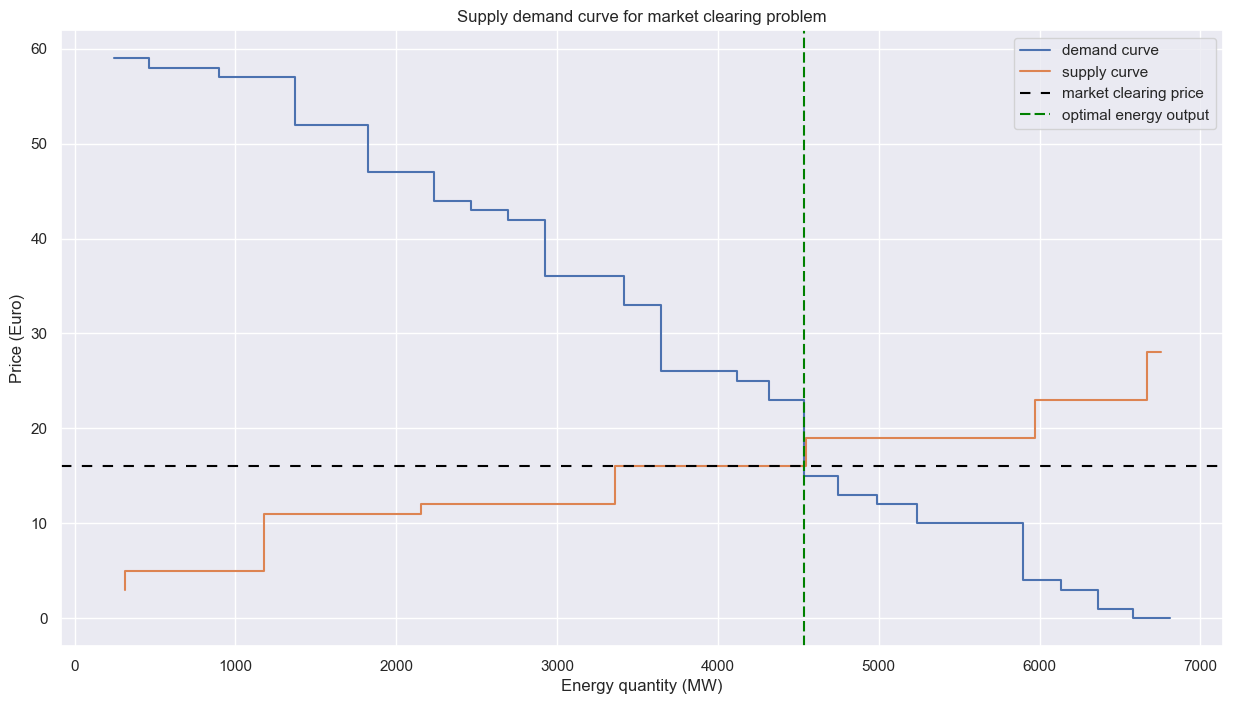

In [29]:
print(f"total demand: {sol_pd.sum()} MW, total supply: {sol_pg.sum()} MW")

print(f"bid price for demand d:\n{U}\noffer price of supply g:\n{C}")

pd_sort_id = np.flip(np.argsort(U))
pg_sort_id = np.argsort(C)

pd_plot = np.cumsum(Pd_max[pd_sort_id])
pg_plot = np.cumsum(Pg_max[pg_sort_id])

fig, ax = plt.subplots(figsize=(15,8))
ax.step(pd_plot, U[pd_sort_id], label="demand curve")
ax.step(pg_plot, C[pg_sort_id], label="supply curve")
ax.axhline(y=16, label="market clearing price", 
           color="black", linestyle=(0, (5, 5)))
ax.axvline(x=sol_pd.sum(), label="optimal energy output", 
           color="green", linestyle=(0, (5, 2)))
ax.legend()
ax.set_xlabel("Energy quantity (MW)")
ax.set_ylabel("Price (Euro)")
plt.title("Supply demand curve for market clearing problem")
#plt.savefig("suppy_demand.png", dpi=100)
plt.show()

## Part 5

<u>Primal-dual interior-point algorithm implementation</u>:

In [30]:
A = np.concatenate((np.ones(len(Pd_max)), -np.ones(len(Pg_max))))[:,np.newaxis]
b = np.array([0])

In [31]:
max_iter = 100
tol = 1e-8
verbose = False
sol_ip, xks, yks, zks, res, iter_ip, converged_ip = lp_ip(gx=g, 
                                                          Aeq=A, 
                                                          beq=b, 
                                                          lb=lb, 
                                                          ub=ub, 
                                                          max_iter=max_iter,
                                                          tol=tol,
                                                          verbose=verbose)

Solving LP using interior-point predictor-corrector method:
Optimal x: 
[2.25000000e+02 2.34000000e+02 2.13000000e+02 2.28000000e+02
 2.31000000e+02 8.57035651e-11 2.18000000e+02 2.84167948e-12
 4.84490436e-10 2.25000000e+02 2.09000000e+02 4.67197009e-11
 2.22000000e+02 2.42000000e+02 1.82690734e-11 2.45000000e+02
 3.09870673e-12 2.17000000e+02 4.00282522e-12 2.42000000e+02
 2.43000000e+02 2.30000000e+02 2.04000000e+02 2.30000000e+02
 1.79304360e-11 4.67167297e-12 2.45000000e+02 1.84586485e-11
 2.30000000e+02 2.03000000e+02 4.15498153e+02 1.22003684e-12
 5.54254258e+02 3.10000000e+02 4.60000000e+02 4.35684804e+01
 1.62679108e+02 4.63381163e-10 4.20000000e+02 3.51933576e-10
 7.85000000e+02 3.10642329e-10 2.48577558e-12 4.10000000e+02
 9.75000000e+02 4.62481997e-13 8.72068737e-13 4.60659384e-13
 6.33213340e-13 6.46328090e-13 2.45000000e+02 4.50812746e-13
 2.32000000e+02 2.10000000e+02 1.13918224e-12 5.82519697e-13
 2.46000000e+02 5.28891279e-13 4.54051383e-13 2.21000000e+02
 7.62517688e-

In [32]:
print(f"objective value: {g.T @ sol_ip[:n]}")
print(f"market clearing price: {-yks[-1,0]}")
print(f"gurobi sol = lp_ip sol: {np.allclose(sol_ip[:n],sol_gurobi_init)}")

print(f"A'x == b: {np.allclose(A.T @ sol_ip[:n],0)}")
print("x within bounds: {}".format(
        np.logical_and(np.all(sol_ip[:n]>=lb-1e-8), 
                       np.all(sol_ip[:n]<=ub+1e-8))))

objective value: -150303.9999999939
market clearing price: 16.000000001140286
gurobi sol = lp_ip sol: False
A'x == b: True
x within bounds: True


In [33]:
print(np.round(sol_ip[:n],decimals=3))

[225.    234.    213.    228.    231.      0.    218.      0.      0.
 225.    209.      0.    222.    242.      0.    245.      0.    217.
   0.    242.    243.    230.    204.    230.      0.      0.    245.
   0.    230.    203.    415.498   0.    554.254 310.    460.     43.568
 162.679   0.    420.      0.    785.      0.      0.    410.    975.   ]


In [34]:
ip_gurobi_diff = sol_gurobi_init - sol_ip[:45]
ip_gurobi_diff_id = np.argwhere(~np.isclose(ip_gurobi_diff,0)).ravel()
print(f"non-zero indexes: {ip_gurobi_diff_id}")
print(f"non-zero values: {ip_gurobi_diff[ip_gurobi_diff_id].ravel()}")

non-zero indexes: [30 32 35 36]
non-zero values: [  4.5018468    5.74574174   1.43151964 -11.67910818]


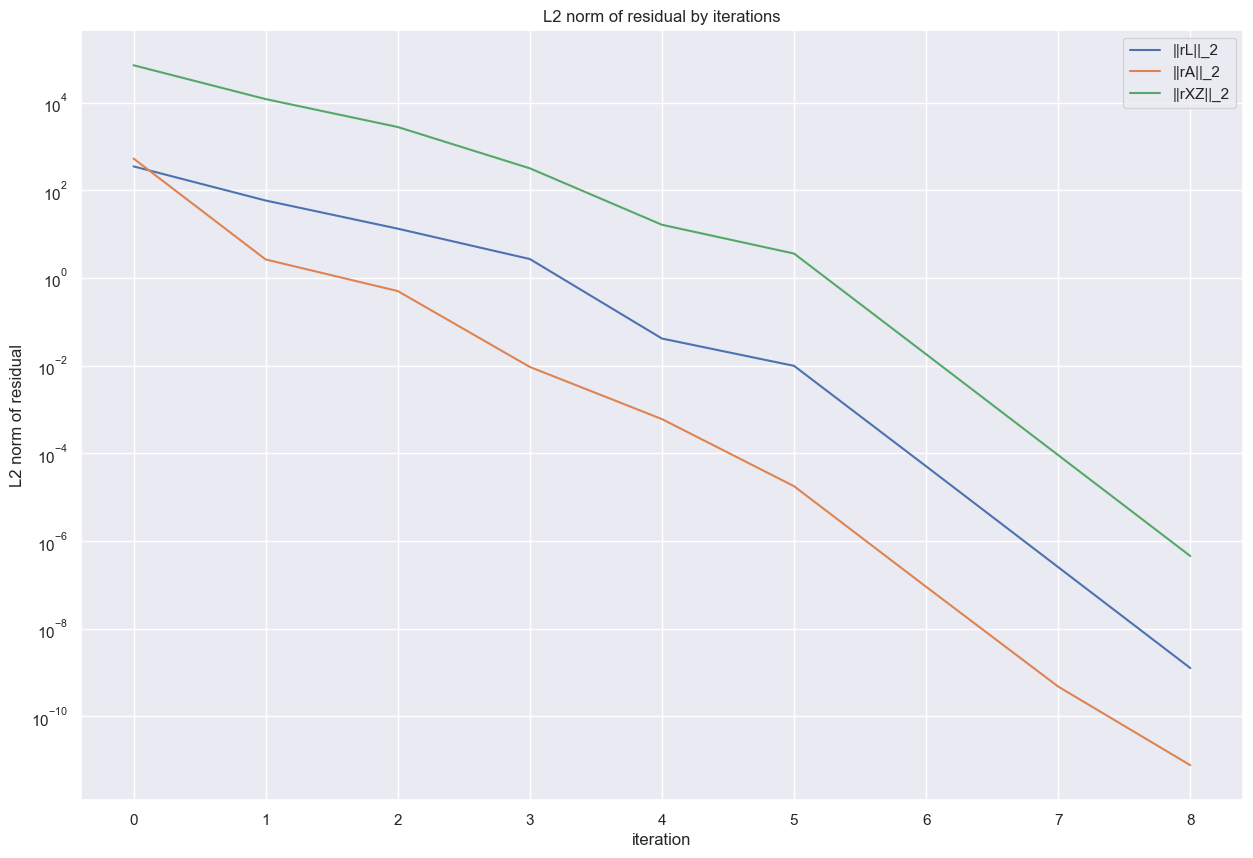

In [35]:
fig, ax = plt.subplots(figsize=(15,10))
ax.semilogy(np.arange(iter_ip), res)
ax.legend(["||rL||_2","||rA||_2","||rXZ||_2"])
ax.set_xlabel("iteration")
ax.set_ylabel("L2 norm of residual")
plt.title("L2 norm of residual by iterations")
#plt.savefig("lp_ip_residuals_plot.png", dpi=100)
plt.show()

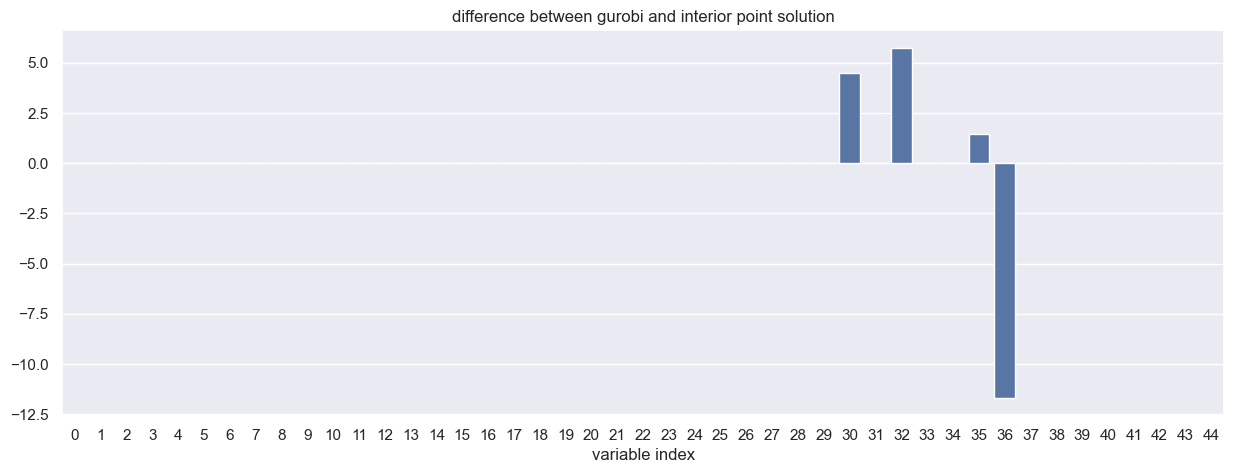

In [36]:
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x=np.arange(45), y=ip_gurobi_diff, legend=None, ax=ax)
ax.set_xlabel("variable index")
plt.title("difference between gurobi and interior point solution")
#plt.savefig("ip_gurobi_diff.png",dpi=100)
plt.show()

## Part 6

<u>Simplex theory</u>:

To apply the simplex, we need to further transform the problem. Due to the lower bound being 0 for all variables, we do not need to add slack variables for the lower bound constraints. We can thus rewrite the problem as the following:

$
\mathrm{min}\, \begin{bmatrix} -U \\ C \\ 0 \\ 0 \end{bmatrix}^\top \begin{bmatrix} P_d \\ P_g \\ s_p \\ s_g \end{bmatrix} \\[1 ex]
\mathrm{st.}\, \begin{bmatrix}  e^\top & -e^\top & 0 & 0 \\ I & 0 & I & 0\\ 0 & I & 0 & I \end{bmatrix} \begin{bmatrix} P_d \\ P_g \\ s_p \\ s_g \end{bmatrix} = \begin{bmatrix} 0 \\ \bar{P_d} \\ \bar{P_g} \end{bmatrix}, \\[1 ex]
\begin{bmatrix} P_d \\ P_g \\ s_p \\ s_g \end{bmatrix} \geq \begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \end{bmatrix}.
$

where $s_p, s_g$ are the slack variables corresponding to the previous upper bound constraints.

let $x=[P_d\,\, P_g]^\top$, $s=[s_p\,\, s_g]^\top$, $g=[-U\,\, C]^\top$, $b=[\bar{P_d}\,\, \bar{P_g}]^\top$ and $c \in \mathbb{R}^n$, where $c_i = \begin{cases} 1 & i \in D\\ -1 & i \in G \end{cases}$. We can then rewrite the problem as follows:

$
\mathrm{min}\, \begin{bmatrix} g \\ 0 \end{bmatrix}^\top \begin{bmatrix} x \\ s \end{bmatrix} \\[1 ex]
\mathrm{st.}\, \begin{bmatrix} c^\top & 0 \\ I & I \end{bmatrix} \begin{bmatrix} x \\ s \end{bmatrix} = \begin{bmatrix} 0 \\ b\end{bmatrix}, \\[1 ex]
\begin{bmatrix} x \\ s \end{bmatrix} \geq \begin{bmatrix} 0 \\ 0 \end{bmatrix}.
$

Due to the nature of the problem, finding an intitial feasible point is trivial:

The only original equality constraint was:

$\underset{d \in D}{\sum}p_d - \underset{g \in G}{\sum}p_g = 0$.

This easily holds if $P_d=0$ and $P_g=0$.

furthermore, we can set the initial slack variable values to be equal to the corresponding upper bound to satisfy new equality constraints. This allows us to analytically find an initial feasible point with ease, skipping phase 1 of the simplex procedure.


## Implementing Simplex Algorithm:

first we need to covert LP into standard form:

A_new: (46, 90)
b_new: (46,)
g_new: (90,)


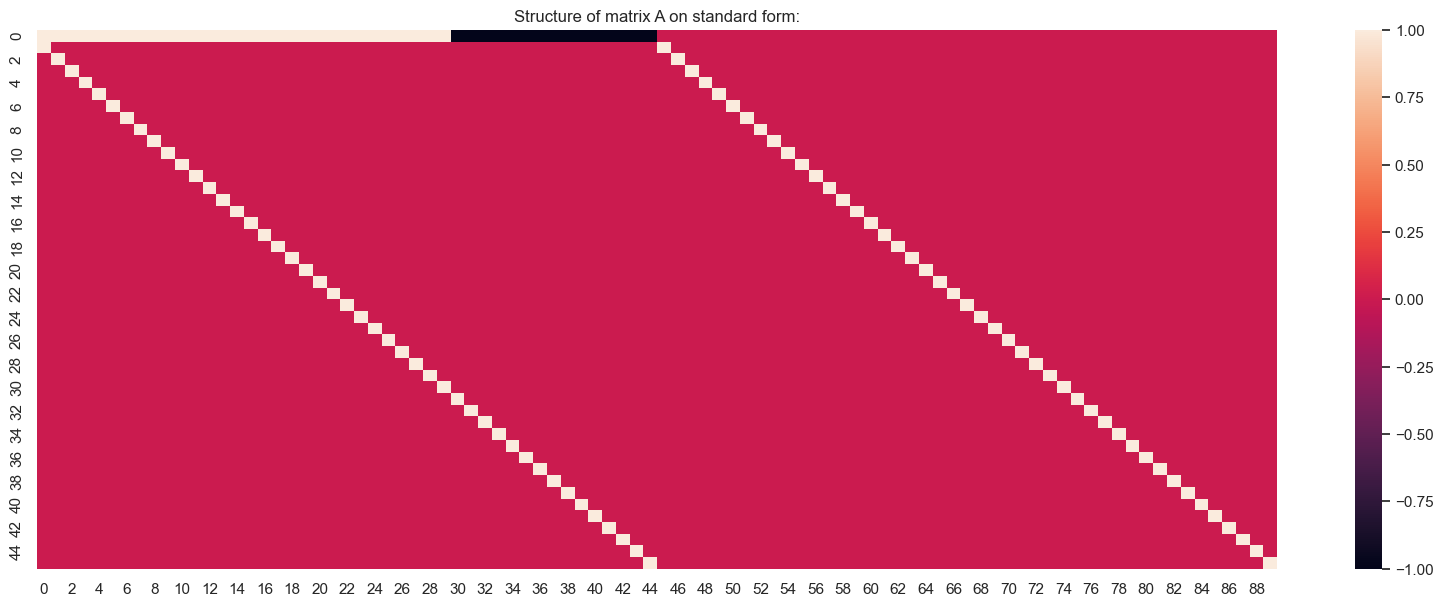

In [37]:
#check phase 1 simplex matrix:
g_new, A_new, b_new = lp_standard_form(g,A.T,b,lb,ub)
print(f"A_new: {A_new.shape}")
print(f"b_new: {b_new.shape}")
print(f"g_new: {g_new.shape}")

fig, ax = plt.subplots(figsize=(20,7))
sns.heatmap(A_new, ax=ax)
plt.title("Structure of matrix A on standard form:")
plt.show()

In [38]:
#check if solution to transformed model corresponds
#with solution to initial model.
model2 = gp.Model("standard form check")

x2 = model2.addMVar(shape=len(g_new), vtype=GRB.CONTINUOUS, name="x", 
                lb=np.zeros(len(g_new)))

c_2 = model2.addConstr(A_new @ x2 == b_new, name="eq constraints")

model2.setObjective(g_new.T @ x2, GRB.MINIMIZE)

model2.optimize()

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 9 5900HS with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 46 rows, 90 columns and 135 nonzeros
Model fingerprint: 0x84c42c25
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+01, 1e+03]
Presolve removed 45 rows and 64 columns
Presolve time: 0.00s
Presolved: 1 rows, 26 columns, 26 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.1731700e+05   8.227500e+02   0.000000e+00      0s
       1   -1.5030400e+05   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.503040000e+05


In [39]:
sol_gurobi_standard = np.array(model2.x)[:n]
print(f"[Pd Pg] = \n{sol_gurobi_standard}")
print(f"market clearing price: {-c_2.Pi[0]}")
print(f"solutions to initial problem and standard form "
      +"problem are the same: {}".format(model2.ObjVal == model1.ObjVal))


[Pd Pg] = 
[225. 234. 213. 228. 231.   0. 218.   0.   0. 225. 209.   0. 222. 242.
   0. 245.   0. 217.   0. 242. 243. 230. 204. 230.   0.   0. 245.   0.
 230. 203. 420.   0. 560. 310. 460.  45. 151.   0. 420.   0. 785.   0.
   0. 410. 975.]
market clearing price: 16.0
solutions to initial problem and standard form problem are the same: True


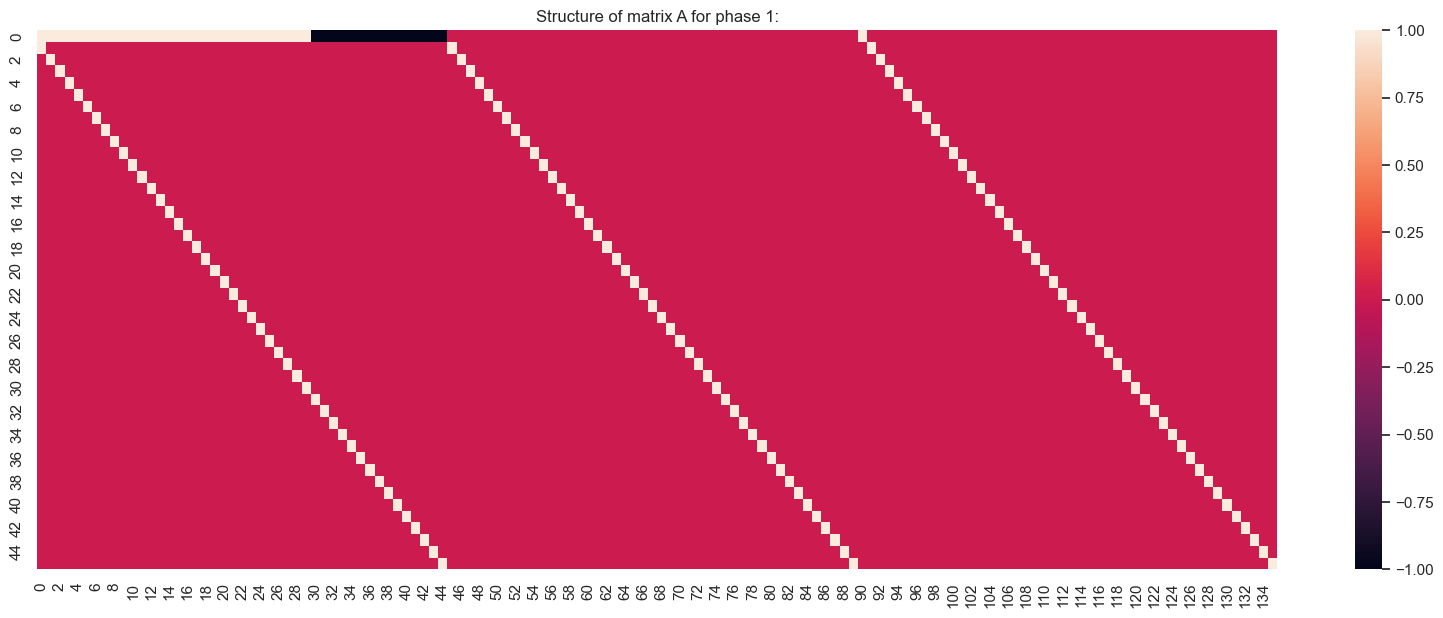

In [40]:
#check LP structure for phase 1:
g_init, A_init, b_init, x0_init, Bx_init, Nx_init = lp_simplex_phase1_form(A_new, b_new)

fig, ax = plt.subplots(figsize=(20,7))
sns.heatmap(A_init, ax=ax)
plt.title("Structure of matrix A for phase 1:")
plt.show()

In [41]:
#check if phase 1 problem is structured correctly:
model3 = gp.Model("phase1 check")

x3 = model3.addMVar(shape=len(g_init), vtype=GRB.CONTINUOUS, name="x", 
                lb=np.zeros(len(g_init)))

model3.addConstr(A_init @ x3 == b_init, name="eq constraints")

model3.setObjective(g_init.T @ x3, GRB.MINIMIZE)

model3.optimize()

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 9 5900HS with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 46 rows, 136 columns and 181 nonzeros
Model fingerprint: 0x054f7c5e
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+01, 1e+03]
Presolve removed 46 rows and 136 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  0.000000000e+00


In [42]:
print("gurobi solution to phase 1:")
print(np.array(model3.x[:90]))
x0_theory = np.concatenate((np.zeros(n), Pd_max, Pg_max))
print("theoretical solution to phase 1:")
print(x0_theory)
print("\ntheoretical = gurobi sol for phase 1: {}".format(
        np.allclose(x0_theory,
                    np.array(model3.x[:2*n]))))

gurobi solution to phase 1:
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0. 225. 234. 213. 228. 231. 245. 218. 232. 210. 225. 209.
 246. 222. 242. 221. 245. 220. 217. 229. 242. 243. 230. 204. 230. 212.
 237. 245. 226. 230. 203. 420.  85. 560. 310. 460.  45. 165. 610. 420.
 430. 785. 385. 695. 410. 975.]
theoretical solution to phase 1:
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0. 225. 234. 213. 228. 231. 245. 218. 232. 210. 225. 209.
 246. 222. 242. 221. 245. 220. 217. 229. 242. 243. 230. 204. 230. 212.
 237. 245. 226. 230. 203. 420.  85. 560. 310. 460.  45. 165. 610. 420.
 430. 785. 385. 695. 410. 975.]

theoretical = gurobi s

In [43]:
ub = np.concatenate((Pd_max,Pg_max))
lb = np.zeros_like(ub)

g = np.concatenate((-U,C))

print("run without bypass:")
sol_simplex1, iters_simplex1 = lp_simplex(g, A, b, lb, ub, 
                                          max_iter=100, 
                                          verbose=False, 
                                          run_phase1=True)

print("\n\nrun with bypass:")
sol_simplex2, iters_simplex2 = lp_simplex(g, A, b, lb, ub, 
                                          max_iter=100, 
                                          verbose=False, 
                                          run_phase1=False)

run without bypass:
Attempting to solve LP using revised simplex algorithm:
Solving phase 1 simplex:
Phase 1 objective: 0.0
solved phase 1 in 0.005475400000250374s and 46 iterations.
solved phase 2 in 0.0017459999999118736s and 16 iterations.
optimal x:
[225. 234. 213. 228. 231.   0. 218.   0.   0. 225. 209.   0. 222. 242.
   0. 245.   0. 217.   0. 242. 243. 230. 204. 230.   0.   0. 245.   0.
 230. 203. 406.   0. 560. 310. 460.  45. 165.   0. 420.   0. 785.   0.
   0. 410. 975.]
optimal objective: -150304.0
total run time: 0.00800970000000234


run with bypass:
Attempting to solve LP using revised simplex algorithm:
phase 1 of simplex has been bypassed.
solved phase 2 in 0.0032350000001315493s and 29 iterations.
optimal x:
[225. 234. 213. 228. 231.   0. 218.   0.   0. 225. 209.   0. 222. 242.
   0. 245.   0. 217.   0. 242. 243. 230. 204. 230.   0.   0. 245.   0.
 230. 203. 420.   0. 560. 310. 460.  45. 151.   0. 420.   0. 785.   0.
   0. 410. 975.]
optimal objective: -150304.0
total ru

In [44]:
print("no bypass solution == gurobi solution: {}".format(
        np.allclose(sol_simplex1, 
                    sol_gurobi_init)))

print("bypass solution == gurobi solution: {}".format(
    np.allclose(sol_simplex2, 
                sol_gurobi_init)))

no bypass solution == gurobi solution: False
bypass solution == gurobi solution: True


index where there is a difference:[30 36]
difference between solutions: [ 14. -14.]


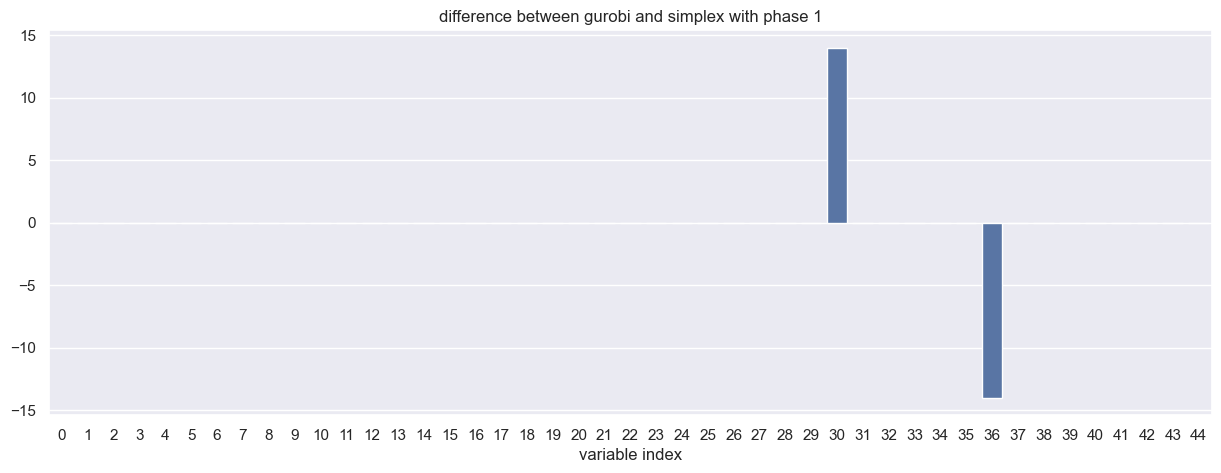

In [25]:
gurobi_simplex1_diff = sol_gurobi_init-sol_simplex1
gurobi_simplex1_diff_id = np.argwhere(gurobi_simplex1_diff != 0).ravel()
print(f"index where there is a difference:{gurobi_simplex1_diff_id}")
print(f"difference between solutions: {}".format(
        gurobi_simplex1_diff[gurobi_simplex1_diff_id]))
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x=np.arange(45), y=sol_gurobi_init-sol_simplex1, legend=None, ax=ax)
ax.set_xlabel("variable index")
plt.title("difference between gurobi and simplex with phase 1")
#plt.savefig("simplex_gurobi_diff.png",dpi=100)
plt.show()